C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-09-16 18:18:20,564] A new study created in memory with name: no-name-2801aeb7-3a1d-471f-b64b-2b092d82f1fa
[I 2024-09-16 18:20:20,245] Trial 0 finished with value: 0.023444226011633873 and parameters: {'n_layers': 4, 'units': 96}. Best is trial 0 with value: 0.023444226011633873.
[I 2024-09-16 18:24:50,823] Trial 1 finished with value: 0.0137516213580966 and parameters: {'n_layers': 3, 'units': 148}. Best is trial 1 with value: 0.0137516213580966.
[I 2024-09-16 18:27:29,147] Trial 2 finished with value: 0.02641875110566616 and parameters: {'n_layers': 4, 'units': 89}. Best is trial 1 with value: 0.013751621

Best parameters: {'n_layers': 1, 'units': 189}
Epoch 1/100
62/62 [==============================] - 14s 199ms/step - loss: 0.0119 - val_loss: 0.0269
Epoch 2/100
62/62 [==============================] - 12s 191ms/step - loss: 0.0012 - val_loss: 0.0192
Epoch 3/100
62/62 [==============================] - 12s 191ms/step - loss: 0.0010 - val_loss: 0.0182
Epoch 4/100
62/62 [==============================] - 12s 190ms/step - loss: 0.0012 - val_loss: 0.0200
Epoch 5/100
62/62 [==============================] - 12s 189ms/step - loss: 9.1957e-04 - val_loss: 0.0167
Epoch 6/100
62/62 [==============================] - 12s 190ms/step - loss: 8.7331e-04 - val_loss: 0.0145
Epoch 7/100
62/62 [==============================] - 12s 190ms/step - loss: 8.1878e-04 - val_loss: 0.0136
Epoch 8/100
62/62 [==============================] - 12s 190ms/step - loss: 8.4599e-04 - val_loss: 0.0138
Epoch 9/100
62/62 [==============================] - 12s 191ms/step - loss: 7.8239e-04 - val_loss: 0.0126
Epoch 10/100
62

ValueError: x and y must have same first dimension, but have shapes (30, 1) and (2786,)

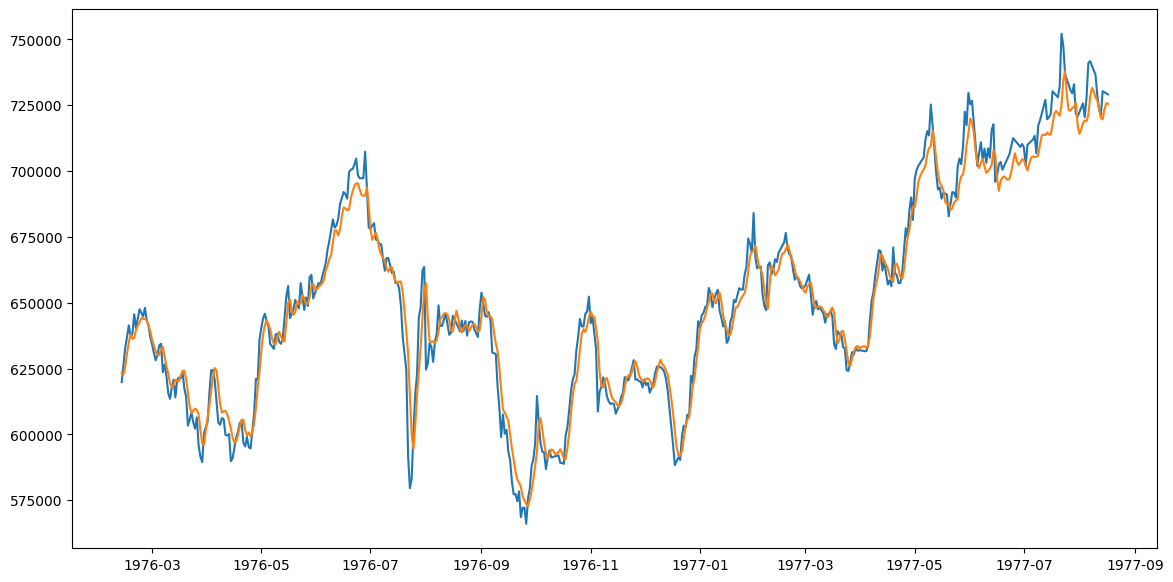

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import optuna

# Load the dataset
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Select relevant columns, exclude 'date' for scaling
columns = ['date', 'gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_lkr']
data = df[columns].copy()

# Train Prophet to capture the trend and seasonality
prophet_df = data[['date', 'gold_lkr']].rename(columns={'date': 'ds', 'gold_lkr': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast future dates using Prophet
future_dates = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future_dates)

# Extract the trend predicted by Prophet
prophet_trend = prophet_forecast[['ds', 'trend']].set_index('ds')
data = data.set_index('date')
data['trend'] = prophet_trend['trend'][:len(data)]

# Calculate residuals (actual - trend)
data['residuals'] = data['gold_lkr'] - data['trend']

# Drop the 'trend' column for LSTM modeling
data_for_lstm = data.drop(columns=['trend'])

# Normalize the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_for_lstm)

# Define window size for LSTM
window_size = 30

# Create sequences for LSTM
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, :])
    y.append(scaled_data[i, -1])  # Predicting 'residuals' (last column)

X, y = np.array(X), np.array(y)

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Define the model with LSTM and Attention
def create_model(n_layers, units):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM layers
    lstm_out = LSTM(units=units, return_sequences=True)(input_layer)
    lstm_out = Dropout(0.2)(lstm_out)
    for _ in range(n_layers - 1):
        lstm_out = LSTM(units=units, return_sequences=True)(lstm_out)
        lstm_out = Dropout(0.2)(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    concat = Concatenate()([lstm_out, attention])
    lstm_out = LSTM(units=units)(concat)
    lstm_out = Dropout(0.2)(lstm_out)
    output_layer = Dense(units=1)(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    units = trial.suggest_int('units', 50, 200)
    
    model = create_model(n_layers, units)
    
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    val_loss = min(history.history['val_loss'])
    
    return val_loss

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best parameters: {study.best_params}')

# Build and train the final model with the best parameters
best_n_layers = study.best_params['n_layers']
best_units = study.best_params['units']

model = create_model(best_n_layers, best_units)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set (predict residuals)
residual_predictions = model.predict(X_test)

# Inverse scaling for residuals and actual values
X_test_inverse = np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1)
residual_predictions = np.concatenate((X_test[:, -1, :-1], residual_predictions), axis=1)
actual_residuals = scaler.inverse_transform(X_test_inverse)[:, -1]
predicted_residuals = scaler.inverse_transform(residual_predictions)[:, -1]

# Combine Prophet trend with LSTM-predicted residuals
actual_gold_prices = actual_residuals + data['trend'].values[split+window_size:]
predicted_gold_prices = predicted_residuals + data['trend'].values[split+window_size:]

# Generate future dates and make future predictions
future_residuals = []
last_sequence = scaled_data[-window_size:]

for date in future_dates[30:]:
    residual_prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_residuals.append(residual_prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], residual_prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future residuals
future_residuals = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_residuals), 1)), np.array(future_residuals).reshape(-1, 1)), axis=1))[:, -1]

# Combine Prophet's future trend and LSTM's future residuals for future predictions
future_gold_prices = future_residuals + prophet_forecast['trend'].values[30:]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df.index[split+window_size:], actual_gold_prices, label='Actual Gold Price')
plt.plot(df.index[split+window_size:], predicted_gold_prices, label='Predicted Gold Price (Hybrid)')
plt.plot(future_dates[-30:], future_gold_prices, label='Future Predictions (Hybrid)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.title('Hybrid Prophet-LSTM Gold Price Prediction')
plt.legend()
plt.show()


1/1 [==============================] - 1s 503ms/step


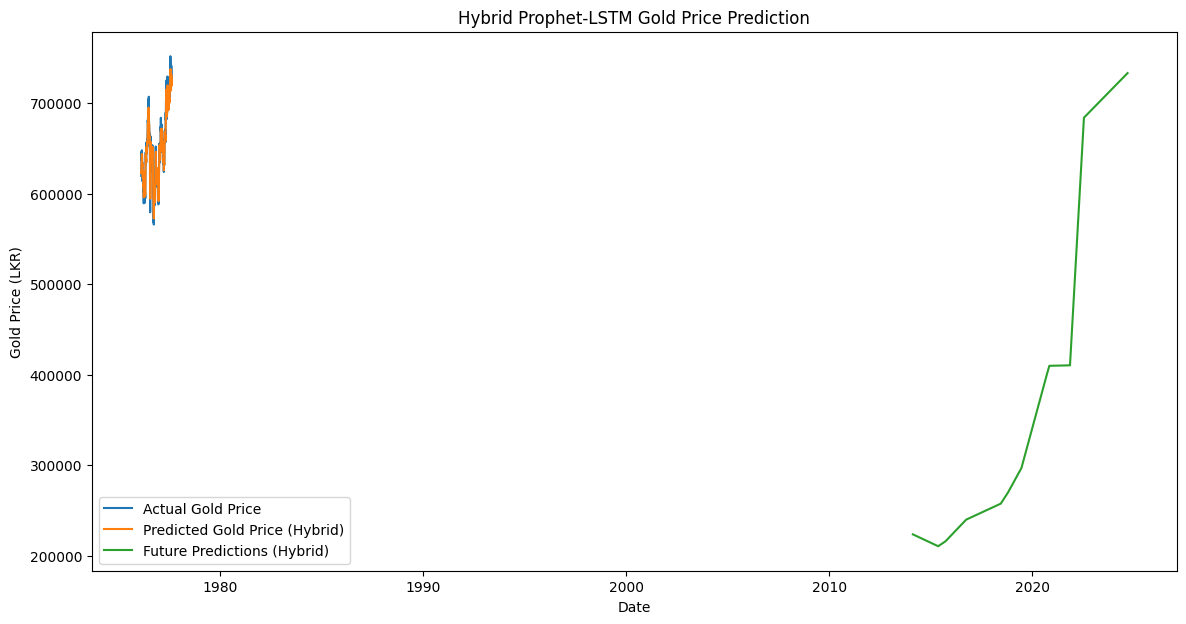

In [2]:
# Generate future dates and make future predictions
future_residuals = []
last_sequence = scaled_data[window_size:]

for date in future_dates[30:]:
    residual_prediction = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_residuals.append(residual_prediction)
    new_sequence = np.append(last_sequence[1:], np.expand_dims(np.append(last_sequence[-1, :-1], residual_prediction), axis=0), axis=0)
    last_sequence = new_sequence

# Inverse scaling for future residuals
future_residuals = scaler.inverse_transform(np.concatenate((np.tile(scaled_data[-1, :-1], (len(future_residuals), 1)), np.array(future_residuals).reshape(-1, 1)), axis=1))[:, -1]

# Combine Prophet's future trend and LSTM's future residuals for future predictions
future_gold_prices = future_residuals + prophet_forecast['trend'].values[30:]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df.index[split+window_size:], actual_gold_prices, label='Actual Gold Price')
plt.plot(df.index[split+window_size:], predicted_gold_prices, label='Predicted Gold Price (Hybrid)')
plt.plot(future_dates[30:], future_gold_prices, label='Future Predictions (Hybrid)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.title('Hybrid Prophet-LSTM Gold Price Prediction')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2816, 1) and (30,)

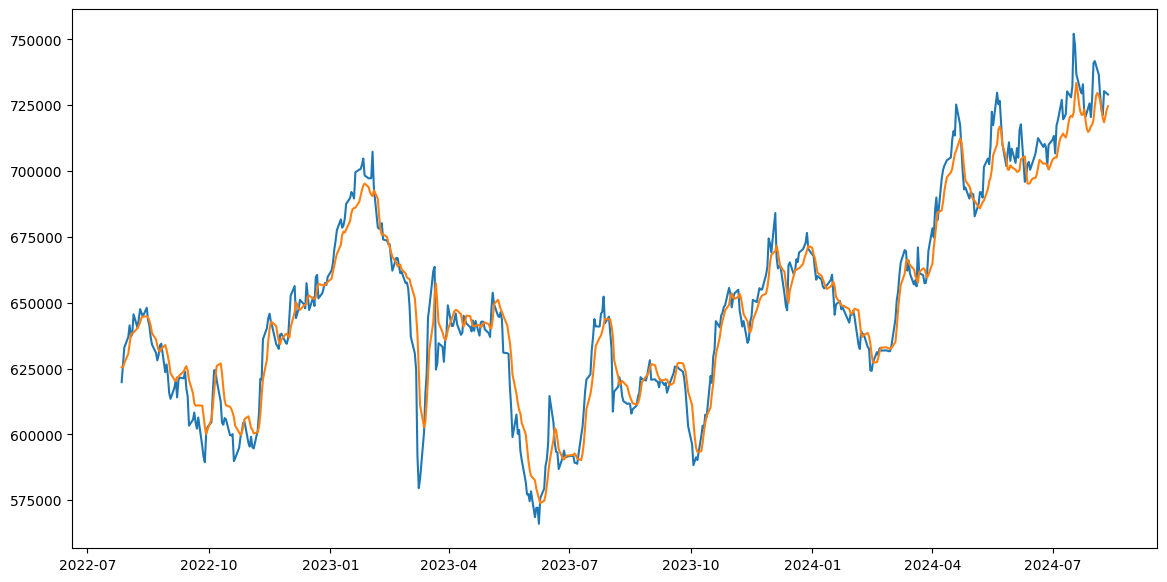

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import optuna

# Load the dataset and ensure 'date' column is in datetime format
df = pd.read_csv('df_interpolated (1).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')  # Ensure correct date format

# ... (rest of your existing preprocessing and model code) ...

# Plot actual vs predicted and future predictions with correct date formatting
plt.figure(figsize=(14, 7))

# Convert the date column to the correct format for plotting
plt.plot(df['date'][split+window_size:], actual_gold_prices, label='Actual Gold Price')
plt.plot(df['date'][split+window_size:], predicted_gold_prices, label='Predicted Gold Price (Hybrid)')
plt.plot(future_dates, future_gold_prices, label='Future Predictions (Hybrid)', color='green')

# Ensure the date format on the x-axis is correct
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.title('Hybrid Prophet-LSTM Gold Price Prediction')
plt.legend()
plt.grid(True)

# Rotate x-axis labels to ensure proper display of dates
plt.xticks(rotation=45)
plt.tight_layout()  # To prevent overlapping of labels

plt.show()


In [10]:
import numpy as np
import pandas as pd

# Assuming 'future_dates' and 'future_gold_prices' have been generated properly
# Ensure future_gold_prices is a 1D array
future_gold_prices = np.array(future_predictions).reshape(-1)  # Flatten the array if needed

# Double-check the lengths before proceeding
print(f"Length of future_dates: {len(future_dates)}")
print(f"Length of future_gold_prices: {len(future_gold_prices)}")

# Ensure the lengths of future_dates and future_gold_prices match
if len(future_dates) != len(future_gold_prices):
    raise ValueError("Mismatch in the length of future dates and future gold prices")

# Create a DataFrame for the results
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Gold_Price_LKR': future_gold_prices
})

# Save the DataFrame to a CSV file
output_file = "forecasted_gold_prices.csv"
forecast_df.to_csv(output_file, index=False)

print(f"Forecasted values have been saved to {output_file}")


Length of future_dates: 2816
Length of future_gold_prices: 30


ValueError: Mismatch in the length of future dates and future gold prices